# Example 1: Function Fitting

In this example, we will cover how to leverage grid refinement to maximimze KANs' ability to fit functions

intialize model and create dataset

In [1]:
from kan import *

seed = 1
torch.manual_seed(seed)

# initialize KAN with G=3
model = KAN(width=[2,1,1], grid=3, k=3, seed=1)

# create dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)

checkpoint directory created: ./model
saving model version 0.0


Train KAN (grid=3)

In [2]:
model.fit(dataset, opt="LBFGS", steps=20);

| train_loss: 1.51e-02 | test_loss: 1.58e-02 | reg: 7.24e+00 | : 100%|█| 20/20 [00:03<00:00,  6.01it

saving model version 0.1


The loss plateaus. we want a more fine-grained KAN!

In [3]:
# initialize a more fine-grained KAN with G=10
model = model.refine(10)

_LinAlgError: torch.linalg.lstsq: (Batch element 0): The least squares solution could not be computed because the input matrix does not have full rank (error code: 12).

Train KAN (grid=10)

In [4]:
model.fit(dataset, opt="LBFGS", steps=20);

train loss: 2.93e-04 | test loss: 3.16e-04 | reg: 5.15e+00 : 100%|██| 20/20 [00:04<00:00,  4.92it/s]


The loss becomes lower. This is good! Now we can even iteratively making grids finer.

In [5]:
grids = np.array([3,10,20,50,100])

seed = 2
torch.manual_seed(seed)

train_losses = []
test_losses = []
steps = 50
k = 3

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=k, seed=seed)
    if i != 0:
        model = model.refine(grids[i])
    results = model.fit(dataset, opt="LBFGS", steps=steps)
    train_losses += results['train_loss']
    test_losses += results['test_loss']
    

Directory already exists: ./model


train loss: 1.44e-02 | test loss: 1.51e-02 | reg: 6.29e+00 : 100%|██| 50/50 [00:09<00:00,  5.17it/s]
train loss: 2.73e-04 | test loss: 3.15e-04 | reg: 6.31e+00 : 100%|██| 50/50 [00:05<00:00,  8.56it/s]
train loss: 1.63e-05 | test loss: 2.15e-05 | reg: 6.31e+00 : 100%|██| 50/50 [00:07<00:00,  6.42it/s]
train loss: 1.46e-06 | test loss: 4.63e-06 | reg: 6.31e+00 : 100%|██| 50/50 [00:12<00:00,  3.92it/s]
train loss: 1.06e+00 | test loss: 1.63e+00 | reg: 5.62e+00 : 100%|██| 50/50 [00:36<00:00,  1.37it/s]


Training dynamics of losses display staircase structures (loss suddenly drops after grid refinement)

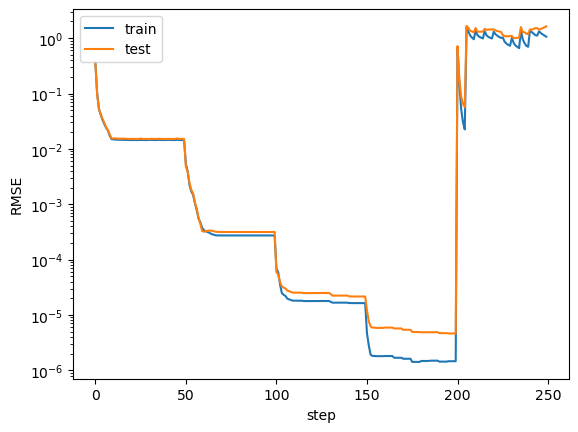

In [8]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

Neural scaling laws

Text(0, 0.5, 'RMSE')

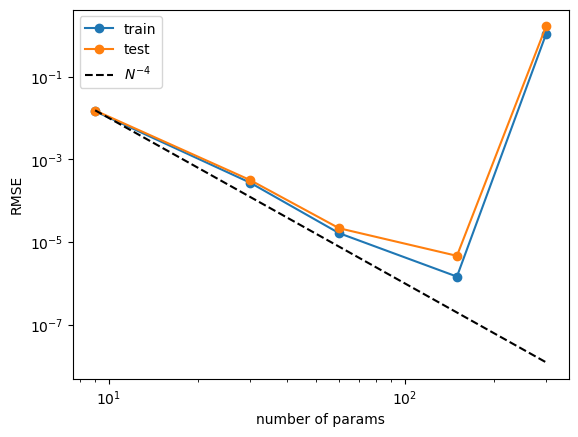

In [9]:
n_params = 3 * grids
train_vs_G = train_losses[(steps-1)::steps]
test_vs_G = test_losses[(steps-1)::steps]
plt.plot(n_params, train_vs_G, marker="o")
plt.plot(n_params, test_vs_G, marker="o")
plt.plot(n_params, 100*n_params**(-4.), ls="--", color="black")
plt.xscale('log')
plt.yscale('log')
plt.legend(['train', 'test', r'$N^{-4}$'])
plt.xlabel('number of params')
plt.ylabel('RMSE')